# Taller de Machine Lerning Pipelines con Python

Los pipelines de machine learning se utilizan para automatizar los flujos de trabajo. Funcionan de tal manera que que se atomiza y encapsula cada uno de los procesos de tal manera que la salida de uno de los pasos es consumida como entrada del siguiente paso. Un ejemplo clásico de un pipeline de Machine Learning sería el siguiente:

![Pipeline de Machine Learning](imgs/machine_learning_pipeline.png)

En este taller vamos a ver un ejemplo de como utilizar los Pipelines de scikit-learn para el preprocesado, ingeniería de variables y entrenamiento de nuestros modelos de machine learning.

Las principales ventajas de los pipelines son las siguientes: 

- El flujo de trabajo es mucho más fácil de leer y de entender
- Fácil utilización de transformadores públicos
- Fácil reutilización de transformadores propios
- Al tener el código atomizado es fácil hacer pruebas cambiando una pieza por otra
- Facilidad de productivización




A continucación importamos las librerías que vamos a utilizar:

In [37]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder
import matplotlib.pyplot as plt

### Nuestro ejemplo: Precio de venta de viviendas en Melbourne

Podéis descargar el dataset que usaremos en este enlace:
[https://www.kaggle.com/dansbecker/melbourne-housing-snapshot](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot)

Las variables con las que vamos a trabajar son las siguientes:

- **Rooms:** Número de habitaciones
- **Type:** br - habitaciones; h - chalet,; u - unidad, duplex; t - adosado; dev site - en desarrollo; o res - otras
- **SellerG:** Agente Inmobiliario
- **Distance:** Distancia al centro de la ciudad
- **Regionname:** Nombre de la región
- **Propertycount:** Número de viviendas en el barrio
- **Bedroom2 :** Número de dormitorios (fuente distinta)
- **Bathroom:** Número de aseos
- **Car:** Plazas de aparcamiento
- **Landsize:** Superficie del terreno
- **BuildingArea:** Superficie de la vivienda
- **CouncilArea:** Junta de Gobierno del área
- **Price:** Precio en dólares (nuestra variable objetivo)

Procedemos a leer y visualizar el dataset:

In [2]:
df= pd.read_csv('data/melb_data.csv',
               usecols=[
                   'Suburb', 'Rooms', 'Type', 'SellerG',
                   'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 
                   'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 
                   'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 
                   'Propertycount','Price'
               ],
               dtype={
                   'Suburb':'str',
                   'Rooms':'int',
                   'Type':'str',
                   'SellerG':'str',
                   'Distance':'float',
                   'Postcode':'str',
                   'Bedroom2':'int',
                   'Bathroom':'int',
                   'Car':'float',
                   'Landsize':'float',
                   'BuildingArea':'float',
                   'YearBuilt':'float',
                   'CouncilArea':'str',
                   'Lattitude':'float',
                   'Longtitude':'float',
                   'Regionname':'str',
                   'Propertycount':'str'
               })
df.head()

,Suburb,Rooms,Type,Price,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,2,h,1480000.0,Biggin,2.5,3067.0,2,1,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,2,h,1035000.0,Biggin,2.5,3067.0,2,1,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,3,h,1465000.0,Biggin,2.5,3067.0,3,2,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,3,h,850000.0,Biggin,2.5,3067.0,3,2,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,4,h,1600000.0,Nelson,2.5,3067.0,3,1,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Descripción de las variables numéricas:

In [38]:
df.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216
std,0.955748,6.393107e+05,5.868725,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810
25%,2.000000,6.500000e+05,6.100000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600
50%,3.000000,9.030000e+05,9.200000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100
75%,3.000000,1.330000e+06,13.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305
max,10.000000,9.000000e+06,48.100000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350


Observamos que existen valores nulos en algunas variables:

In [39]:
df.isnull().any()

Suburb           False
Rooms            False
Type             False
Price            False
SellerG          False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car               True
Landsize         False
BuildingArea      True
YearBuilt         True
CouncilArea       True
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

Dividimos el dataset en Train (80%) y Test (20%) cogiendo como variable objetivo (`y`) el precio (`Price`):

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1), 
                                                    df['Price'], 
                                                    test_size=0.2,
                                                    random_state=707)

Creamos listados de las columnas numéricas y categóricas que nos resultarán útiles a la hora de realizar el preprocesado:

In [5]:
numeric_cols = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 
                'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 
                'Lattitude', 'Longtitude', 'Propertycount']
categoric_cols = ['Suburb', 'Type', 'SellerG', 'Postcode', 
                  'CouncilArea','Regionname',]

### Nuestro primer Pipeline

A continuación vamos a crear nuestro primer pipeline. En esta primera aproximación **sólo utilizaremos las variables numéricas**.

![Primer Pipeline](imgs/primer_pipeline.png)

Para crear nuestros pipeline primero definimos cada uno de los objetos del mismo:
1. Imputar nulos mediante `SimpleImputer`
2. Reescalar los datos con `StandardScaler`
3. Regresión lineal mediante `LinearRegression`

In [46]:
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
lr = LinearRegression()

Creamos una lista de tuplas en las que cada tupla corresponde a un par de `('nombre del paso', objeto)`.

In [ ]:
steps = [
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', lr)
]

Para crear el pipeline sólo tenemos que utilizar `Pipeline` de scikit-learn y pasarle la lista de tuplas:

In [ ]:
pipeline_first = Pipeline(steps)

#### ¿Cómo podemos utilizar los pipelines?
##### transform
Cuando utilizamos el método `transform` en el pipeline es como si hiciemos `transform` uno a uno en cada uno de los objetos:
![transform](imgs/transform.png)

In [51]:
pipeline_first.transform(X_train[numeric_cols], y_train)

AttributeError: 'RandomForestRegressor' object has no attribute 'transform'

Nos da error porque el regresor (el último paso) no tiene método `transform`.

Estos son otros métodos del pipeline:
##### fit_transform
Cuando utilizamos el método `fit_transform` en el pipeline es como si hiciemos `fit_transform` uno a uno en cada uno de los objetos (o primero `fit` seguido de `transform` si el objeto no tiene ese método):
![fit_transform](imgs/fit_transform.png)

##### fit
Cuando utilizamos el método `fit` en el pipeline es como si hiciemos `fit_transform` (o primero `fit` seguido de `transform` si el objeto no tiene ese método) uno a uno en cada uno de los objetos hasta llegar al último donde hace un `fit`:
![fit](imgs/fit.png)

##### predict
Cuando utilizamos el método `predict` (funciona de la misma manera con `predict_proba`) en el pipeline es como si hiciemos `transform` uno a uno en cada uno de los objetos hasta llegar al último donde hace un `predict`.:
![predict](imgs/predict.png)

Vamos a probar a entrenar nuestro pipeline:

In [47]:
pipeline_first.fit(X_train[numeric_cols], y_train)

Pipeline(steps=[('numeric_imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Realizamos una predicción del dataset de train y calculamos la raíz del error cuadrático medio que será nuestra métrica en este workshop:

In [48]:
y_train_pred = pipeline_first.predict(X_train[numeric_cols])
mean_squared_error(y_train, y_train_pred, squared=False)

442318.51141938695

Si queremos cambiar el regresor sólo tenemos que volver a crear el Pipeline cambiando el paso del regresor. Como se puede ver sería muy fácil iterar con distintos regresores para poder evaluarlos:

In [50]:
rf = RandomForestRegressor()

steps = [
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', rf)
]

pipeline_second = Pipeline(steps)
pipeline_second.fit(X_train[numeric_cols], y_train)

y_train_pred = pipeline_second.predict(X_train[numeric_cols])
mean_squared_error(y_train, y_train_pred, squared=False)

111396.35535260449

### Pipeline Sencillo

In [9]:
def select_numeric(df):
    return df.select_dtypes(include=['int64', 'float64'])

In [10]:
sel_numeric = FunctionTransformer(select_numeric, validate=False)

In [11]:
steps = [
    ('select_numeric', sel_numeric),
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', rf)
]
pipeline_easy = Pipeline(steps)

In [12]:
param_grid = {
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_easy, 
                          cv=5, 
                          n_iter=10, 
                          n_jobs=10, 
                          param_distributions=param_grid, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('select_numeric',
                                              FunctionTransformer(func=<function select_numeric at 0x7f0d4c5f2e50>)),
                                             ('numeric_imputer',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', StandardScaler()),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_jobs=10,
                   param_distributions={'regressor__bootstrap': [True],
                                        'regressor__max_depth': [80, 90, 100,
                                                                 110],
                                        'regressor__max_features': [2, 3],
                                        'regressor__min_samples_leaf': [3, 4,
                                   

In [13]:
-rscv.best_score_

303725.33031275525

### Pipeline Medio 

In [14]:
pipeline_num = Pipeline([('numeric_imputer', num_imputer), ('scaler', scaler)])
encoder = OrdinalEncoder()
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('categoric_prep', encoder, categoric_cols)])

In [15]:
pipeline_medium = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

In [16]:
rscv = RandomizedSearchCV(pipeline_medium, 
                          cv=5, 
                          n_iter=10, 
                          n_jobs=10, 
                          param_distributions=param_grid, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('numeric_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Bedroom2',
                                                                           

In [17]:
-rscv.best_score_

297569.95740313566

### Pipeline Avanzado 

In [18]:
target_encoder = LeaveOneOutEncoder()
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('ordindal_encoder', encoder, ['Type', 'CouncilArea', 'Regionname']),
                                   ('target_encoder', target_encoder, ['Suburb', 'SellerG', 'Postcode'])])

In [19]:
pipeline_advanced = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

In [20]:
params = {
    'preprocessing__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_advanced, 
                          cv=5, 
                          n_iter=20, 
                          n_jobs=10, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('numeric_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Bedroom2',
                                                                           

In [21]:
rscv.best_params_

{'regressor__n_estimators': 1000,
 'regressor__min_samples_split': 8,
 'regressor__min_samples_leaf': 3,
 'regressor__max_features': 3,
 'regressor__max_depth': 80,
 'regressor__bootstrap': True,
 'preprocessing__target_encoder__sigma': 0.02}

In [22]:
-rscv.best_score_

293598.43810455856

### Pipelines con Transformadores Propios 

In [23]:
class KMeansLatLon(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_clusters=10):
        self.columns = columns
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=self.n_clusters)

    def fit(self, X, y=None):
        self.model.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        data = X.copy()
        pred = self.model.predict(data[self.columns])
        data['LatLonCluster'] = pred
        return data 

In [24]:
example_cluster = KMeansLatLon(['Lattitude', 'Longtitude'], n_clusters=20)

In [25]:
X_train_latlon = example_cluster.fit_transform(X_train)

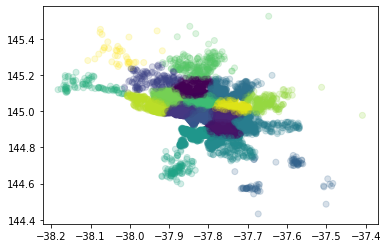

In [26]:
plt.scatter(X_train_latlon['Lattitude'],
            X_train_latlon['Longtitude'],
            c=X_train_latlon['LatLonCluster'],
            alpha=0.2)

In [27]:
kmeanslatlon = KMeansLatLon(['Lattitude', 'Longtitude'])
pipeline_num = Pipeline([('latlon_cluster', kmeanslatlon), 
                         ('numeric_imputer', num_imputer)])

In [28]:
target_encoder = LeaveOneOutEncoder()
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('ordindal_encoder', encoder, ['Type', 'CouncilArea', 'Regionname']),
                                   ('target_encoder', target_encoder, ['Suburb', 'SellerG', 'Postcode'])])

In [29]:
pipeline_with_clusters = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

In [30]:
params = {
    'preprocessing__numeric_prep__latlon_cluster__n_clusters': [5, 10, 20],
    'preprocessing__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_with_clusters, 
                          cv=5, 
                          n_iter=20, 
                          n_jobs=10, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('latlon_cluster',
                                                                                                KMeansLatLon(columns=['Lattitude',
                                                                                                                      'Longtitude'])),
                                                                                               ('numeric_imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['Rooms',
                                                                                'Distance',
        

In [33]:
rscv.best_params_

{'regressor__n_estimators': 200,
 'regressor__min_samples_split': 8,
 'regressor__min_samples_leaf': 3,
 'regressor__max_features': 3,
 'regressor__max_depth': 80,
 'regressor__bootstrap': True,
 'preprocessing__target_encoder__sigma': 0.02,
 'preprocessing__numeric_prep__latlon_cluster__n_clusters': 5}

In [31]:
-rscv.best_score_

294155.05387907044

In [32]:
rscv.best_estimator_['regressor'].feature_importances_

array([0.08087523, 0.04992365, 0.06352024, 0.0525268 , 0.01955322,
       0.07511832, 0.06247033, 0.03092528, 0.04481139, 0.03651784,
       0.01369081, 0.02427008, 0.09062572, 0.0116357 , 0.01018077,
       0.13640336, 0.07001524, 0.12693602])

### Test 

In [35]:
y_pred = rscv.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

280136.54889356566